In [1]:
!pip install torchmetrics

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
%cd /app/_data/EfficientNet-PyTorch
!pip install -e .

/app/_data/EfficientNet-PyTorch
Obtaining file:///app/_data/EfficientNet-PyTorch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: efficientnet-pytorch
    Found existing installation: efficientnet-pytorch 0.7.1
    Can't uninstall 'efficientnet-pytorch'. No files were found to uninstall.
  Running setup.py develop for efficientnet-pytorch
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import ast
import glob
import json
import os
import re
import shutil
import sys

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from torchvision.ops import box_iou
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import torchmetrics
from IPython.display import clear_output
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    StratifiedGroupKFold,
    StratifiedKFold,
)
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image

In [4]:
TRAIN_DF_PART = "/app/_data/tensorflow-great-barrier-reef/train.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 38
DEVICE

'cuda'

## Dataset

In [5]:
df = pd.read_csv(TRAIN_DF_PART)
df["img_path"] = (
    "/app/_data/tensorflow-great-barrier-reef/train_images/video_"
    + df.video_id.astype("str")
    + "/"
    + df.video_frame.astype("str")
    + ".jpg"
)
df["annotations"] = df["annotations"].apply(lambda x: ast.literal_eval(x))
df["len_annotation"] = df["annotations"].str.len()
df["image_id"] = df["image_id"].str.replace("-", "_", regex=True)
df["new_img_path"] = f"/app/_data/images/" + df["image_id"] + ".jpg"
df["label"] = df["len_annotation"].apply(lambda x: 0 if x == 0 else 1)
df["no_label"] = df["len_annotation"].apply(lambda x: True if x == 0 else False)

In [6]:
df["label_change"] = df["label"] & df["no_label"].shift(1) & df["no_label"].shift(
    2
) | df["no_label"] & df["label"].shift(1) & df["label"].shift(2)
df["sequense_change"] = df["sequence"] != df["sequence"].shift(1)
df["start_subseq"] = df["sequense_change"] | df["label_change"]
df.loc[df.index[-1], "start_subseq"] = True
df["start_subseq"].sum()

138

In [7]:
start_idx = 0
for subsequence_id, end_idx in enumerate(df[df["start_subseq"]].index):
    df.loc[start_idx:end_idx, "subsequence_id"] = subsequence_id
    start_idx = end_idx

df["subsequence_id"] = df["subsequence_id"].astype(int)
df["subsequence_id"].nunique()

137

In [8]:
cut_df = pd.read_csv("/app/_data/cut_df.csv")
cut_df.sample(10)

,image_id,new_img_id,label,bboxes,n_bboxes,npy_path
6810,0_1583,0_1583_4,0,NaN,0,/app/_data/npy_380/0_1583_4.npy
9486,0_2160,0_2160_2,0,NaN,0,/app/_data/npy_380/0_2160_2.npy
92373,1_11222,1_11222_2,0,NaN,0,/app/_data/npy_380/1_11222_2.npy
131807,2_6110,2_6110_5,0,NaN,0,/app/_data/npy_380/2_6110_5.npy
27570,0_8184,0_8184_5,0,NaN,0,/app/_data/npy_380/0_8184_5.npy
2129,0_904,0_904_4,0,NaN,0,/app/_data/npy_380/0_904_4.npy
24647,0_7819,0_7819_2,0,NaN,0,/app/_data/npy_380/0_7819_2.npy
28757,0_8399,0_8399_6,0,NaN,0,/app/_data/npy_380/0_8399_6.npy
133415,2_6424,2_6424_4,1,0 214 22 254,1,/app/_data/npy_380/2_6424_4.npy
2689,0_1045,0_1045_5,0,NaN,0,/app/_data/npy_380/0_1045_5.npy


In [9]:
cut_df["negative"] = cut_df["label"].replace({1: 0, 0: 1})

In [10]:
cut_df = cut_df.merge(
    df[["image_id", "sequence", "subsequence_id"]], on="image_id", how="left"
)

In [11]:
n_splits = 6
kf = GroupKFold(n_splits=n_splits)
list_train_ids = []
list_val_ids = []
for kfold, (train_idx, val_idx) in enumerate(
    kf.split(cut_df, y=cut_df.negative, groups=cut_df.sequence)
):
    list_train_ids.append(train_idx)
    list_val_ids.append(val_idx)
    print(
        kfold,
        cut_df.loc[list_train_ids[kfold]].query("negative==0").shape[0],
        cut_df.loc[list_val_ids[kfold]].query("negative==0").shape[0],
        cut_df.loc[list_train_ids[kfold]].query("negative==0").shape[0]
        / (cut_df.loc[list_val_ids[kfold]].query("negative==0").shape[0] + 1),
    )

0 9120 491 18.536585365853657
1 9580 31 299.375
2 7470 2141 3.4873949579831933
3 5622 3989 1.4090225563909775
4 7990 1621 4.926017262638718
5 8273 1338 6.1784914115011205


In [12]:
KFOLD = 5
cut_df.loc[list_train_ids[KFOLD]]["sequence"].unique()
cut_df.loc[list_train_ids[KFOLD]].shape
cut_df.loc[list_val_ids[KFOLD]]["sequence"].unique()
cut_df.loc[list_val_ids[KFOLD]].shape

array([40258, 45518, 45015, 53708,   996, 44160, 15827, 29424,  8503,
       18048, 17665, 60754, 37114, 26651, 22643, 29859])

(132393, 9)

array([59337,  8399, 35305, 60510])

(25874, 9)

In [13]:
print(
    KFOLD,
    cut_df.loc[list_train_ids[KFOLD]].query("negative==0").shape[0],
    cut_df.loc[list_val_ids[KFOLD]].query("negative==0").shape[0],
    cut_df.loc[list_train_ids[KFOLD]].query("negative==0").shape[0]
    / cut_df.loc[list_val_ids[KFOLD]].query("negative==0").shape[0],
)

5 8273 1338 6.183109118086697


# Dataloader

In [14]:
transform = A.Compose(
    [
        A.Blur(blur_limit=3, p=0.05),
        A.MedianBlur(blur_limit=3, p=0.05),
        A.ToGray(p=0.01),
        A.RandomBrightnessContrast(
            brightness_limit=0.05,
            contrast_limit=0.05,
            brightness_by_max=True,
            p=0.1,
        ),
        A.RandomGamma(p=0.05),
        A.ImageCompression(quality_lower=95, p=0.05),
        A.Sharpen(alpha=(0.2, 0.3), lightness=(0.5, 1.0), p=0.05),
        A.HueSaturationValue(
            hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.05
        ),
        A.RGBShift(p=0.05),
        A.Flip(p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.2, scale_limit=[0.1, 0.2], rotate_limit=[10, 45], p=0.01
        ),
        A.RandomRain(
            slant_lower=-10,
            slant_upper=10,
            drop_length=20,
            drop_width=1,
            drop_color=(200, 200, 200),
            blur_value=7,
            brightness_coefficient=0.6,
            rain_type="drizzle",
            p=0.05,
        ),
    ],
)

In [15]:
class CustomImageDataset(Dataset):
    def __init__(
        self,
        df,
        img_size,
        label_col="label",
        shuffle=False,
        augment=True,
        transform_fn=None,
    ):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.label_col = label_col
        self.shuffle = shuffle
        self.augment = augment
        self.transform_fn = transform_fn
        self.to_tens = transforms.Compose([transforms.ToTensor()])
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, ix):
        img_path = self.df.loc[ix, "npy_path"]
        img = np.load(img_path)
        label = self.df.loc[ix, self.label_col]
        if img.shape[:2] != self.img_size:
            img = np.resize(img, self.img_size)

        if self.augment:
            img = self.transform_fn(image=img)["image"]
        img = img - img.min()
        img = img / img.max()
        img = img.transpose(2, 0, 1).astype("float32")
        return img, label.astype("int8")

In [16]:
train = pd.concat(
    [
        cut_df.loc[list_train_ids[KFOLD]].query("negative==0"),
        cut_df.loc[list_train_ids[KFOLD]]
        .query("negative==1")
        .sample(
            cut_df.loc[list_train_ids[KFOLD]].query("negative==0").shape[0]*2,
            random_state=SEED,
        ),
    ],
    ignore_index=True,
)
val = pd.concat(
    [
        cut_df.loc[list_val_ids[KFOLD]].query("negative==0"),
        cut_df.loc[list_val_ids[KFOLD]]
        .query("negative==1")
        .sample(
            cut_df.loc[list_val_ids[KFOLD]].query("negative==0").shape[0]*9,
            random_state=SEED,
        ),
    ],
    ignore_index=True,
)

In [17]:
val.query("negative==1").shape
val.query("negative==0").shape

(12042, 9)

(1338, 9)

In [18]:
train.query("negative==1").shape
train.query("negative==0").shape

(16546, 9)

(8273, 9)

In [19]:
train_gen = CustomImageDataset(
    df=train,
    img_size=(380, 380),
    label_col="negative",
    shuffle=True,
    augment=True,
    transform_fn=transform,
)
val_gen = CustomImageDataset(
    df=val,
    img_size=(380, 380),
    label_col="negative",
    shuffle=True,
    augment=False,
    transform_fn=transform,
)

In [20]:
img, label = train_gen.__getitem__(55)

In [21]:
label

1

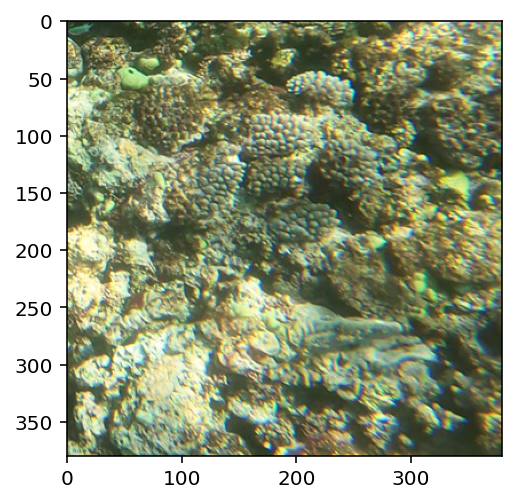

In [22]:
plt.imshow(img.transpose(1, 2, 0))

# model

In [23]:
# efficientnet = torch.hub.load(
#     "NVIDIA/DeepLearningExamples:torchhub", "nvidia_efficientnet_b4", pretrained=True
# )

# for param in efficientnet.parameters():
#     efficientnet.requires_grad = True
# in_features = efficientnet.classifier.fc.in_features
# efficientnet.classifier.fc = torch.nn.Linear(in_features, 1)
# efficientnet.classifier
# efficientnet = efficientnet.to(DEVICE)

In [24]:
from efficientnet_pytorch import EfficientNet

efficientnet = EfficientNet.from_pretrained('efficientnet-b7')

for param in efficientnet.parameters():
    efficientnet.requires_grad = True

efficientnet._fc

in_features = efficientnet._fc.in_features
efficientnet._fc = torch.nn.Linear(in_features, 1)
efficientnet._fc
efficientnet = efficientnet.to(DEVICE)

Loaded pretrained weights for efficientnet-b7


Linear(in_features=2560, out_features=1000, bias=True)

Linear(in_features=2560, out_features=1, bias=True)

# train

In [25]:
train_dataloader = DataLoader(train_gen, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_gen, batch_size=32, shuffle=True)

In [26]:
num_steps = len(train_dataloader)
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.0005)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", factor=0.5, patience=20, verbose=True
)
loss_fn = torch.nn.BCELoss()

In [27]:
train_metrics = torchmetrics.MetricCollection(
    [
        torchmetrics.Accuracy(compute_on_step=False),
        torchmetrics.Precision(compute_on_step=False),
        torchmetrics.Recall(compute_on_step=False),
        torchmetrics.F1Score(compute_on_step=False),
    ]
)
val_metrics = torchmetrics.MetricCollection(
    [
        torchmetrics.Accuracy(compute_on_step=False),
        torchmetrics.Precision(compute_on_step=False),
        torchmetrics.Recall(compute_on_step=False),
        torchmetrics.F1Score(compute_on_step=False),
    ]
)

In [28]:
def train_loop(
    model,
    dataloader,
    optimizer,
    device,
    loss_fn,
    metric_fn,
    act_fn=torch.nn.Sigmoid(),
):
    train_loss = []
    model = model.train()
    for (imgs, targets) in tqdm(dataloader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = act_fn(model(imgs))
        loss = loss_fn(output.squeeze(), targets.float())
        train_loss.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        metric_fn.to(device)(output.squeeze(), targets)
    met = metric_fn.compute()
    acc = met["Accuracy"].detach().cpu().numpy()
    prec = met["Precision"].detach().cpu().numpy()
    recall = met["Recall"].detach().cpu().numpy()
    f1 = met["F1Score"].detach().cpu().numpy()
    metric_fn.reset()
    mean_train_loss = np.array(train_loss).mean()

    print(
        f"Train loss: {mean_train_loss}, accuracy: {acc}, recall: {recall}, precision {prec}, f1score: {f1}"
    )
    return mean_train_loss, acc, recall, prec, f1


def eval_loop(model, dataloader, device, loss_fn, metric_fn, act_fn=torch.nn.Sigmoid()):
    model = model.eval()
    val_labels = []
    val_outputs = []
    val_loss = []
    with torch.no_grad():
        for (imgs, targets) in tqdm(dataloader):
            val_labels.extend(targets.numpy().tolist())
            imgs = imgs.to(device)
            targets = targets.to(device)
            output = act_fn(model(imgs))
            loss = loss_fn(output.squeeze(), targets.float())
            val_outputs.extend(output.detach().cpu().numpy().tolist())
            val_loss.append(loss.detach().cpu().numpy())
            metric_fn.to(device)(output.squeeze(), targets)
    met = metric_fn.compute()
    acc = met["Accuracy"].detach().cpu().numpy()
    prec = met["Precision"].detach().cpu().numpy()
    recall = met["Recall"].detach().cpu().numpy()
    f1 = met["F1Score"].detach().cpu().numpy()
    metric_fn.reset()
    mean_val_loss = np.array(val_loss).mean()

    print(
        f"Val loss: {mean_val_loss}, accuracy: {acc}, recall: {recall}, precision {prec}, f1score: {f1}"
    )
    return val_outputs, val_labels, mean_val_loss, acc, recall, prec, f1

In [ ]:
best_loss = 10
best_acc = 0
best_recall = 0
best_precision = 0
best_f1 = 0
n = 100
act_fn=torch.nn.Sigmoid()
for epoch in range(100):
    print(
        f"==================================================================== epoch {epoch} ===================================================================="
    )
    train_loss = []
    efficientnet = efficientnet.train()
    for tr, (imgs, targets) in tqdm(enumerate(train_dataloader)):
        imgs = imgs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = act_fn(efficientnet(imgs))
        loss = loss_fn(output.squeeze(), targets.float())
        train_loss.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        train_metrics.to(device)(output.squeeze(), targets)
        if tr % 100 == 0:
            met = train_metrics.compute()
            train_acc = met["Accuracy"].detach().cpu().numpy()
            train_prec = met["Precision"].detach().cpu().numpy()
            train_recall = met["Recall"].detach().cpu().numpy()
            train_f1 = met["F1Score"].detach().cpu().numpy()
            train_metrics.reset()
            mean_train_loss = np.array(train_loss).mean()
            train_loss = []
            print(
                f"Train loss: {mean_train_loss}, accuracy: {acc}, recall: {recall}, precision {prec}, f1score: {f1}"
            )
                (
            val_outputs,
            val_labels,
            mean_val_loss,
            val_acc,
            val_recall,
            val_prec,
            val_f1,
        ) = eval_loop(
            model=efficientnet,
            dataloader=val_dataloader,
            device=DEVICE,
            loss_fn=loss_fn,
            metric_fn=val_metrics,
            act_fn=torch.nn.Sigmoid(),
        )
        wandb.log(
            {
                "train_loss": mean_train_loss,
                "train_accuracy": train_acc,
                "train_recall": train_recall,
                "train_precision": train_prec,
                "train_f1score": train_f1,
                "val_loss": mean_val_loss,
                "val_accuracy": val_acc,
                "val_recall": val_recall,
                "val_precision": val_prec,
                "val_f1score": val_f1,
            }
        )
        
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            torch.save(
                {
                    "epoch": {epoch},
                    "model_state_dict": efficientnet.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss_fn,
                    "mean_loss": mean_val_loss,
                },
                f"/app/_data/eff_luk/effb7_2.pth",
            )
            n = 100
        else:
            n -= 1
        if val_recall > best_recall:
            best_recall = val_recall
            torch.save(
                {
                    "epoch": {epoch},
                    "model_state_dict": efficientnet.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss_fn,
                    "mean_loss": mean_val_loss,
                },
                f"/app/_data/eff_luk/effb7_2_best_rec.pth",
            )
        if n == 0:
            print('EarlyStopping')
            break
        sched.step(mean_val_loss)

In [29]:
# !pip install --upgrade wandb
# clear_output()
import wandb

wandb.login()

wandb: Currently logged in as: tatanko (use `wandb login --relogin` to force relogin)


True

In [30]:
wandb.init(project="effnet_v1")

In [31]:
# Magic
wandb.watch(efficientnet)

[]

In [32]:
best_loss = 10
best_acc = 0
best_recall = 0
best_precision = 0
best_f1 = 0
n = 15
for epoch in range(100):
    print(
        f"==================================================================== epoch {epoch} ===================================================================="
    )
    mean_train_loss, train_acc, train_recall, train_prec, train_f1 = train_loop(
        model=efficientnet,
        dataloader=train_dataloader,
        optimizer=optimizer,
        device=DEVICE,
        loss_fn=loss_fn,
        metric_fn=train_metrics,
        act_fn=torch.nn.Sigmoid(),
    )

    (
        val_outputs,
        val_labels,
        mean_val_loss,
        val_acc,
        val_recall,
        val_prec,
        val_f1,
    ) = eval_loop(
        model=efficientnet,
        dataloader=val_dataloader,
        device=DEVICE,
        loss_fn=loss_fn,
        metric_fn=val_metrics,
        act_fn=torch.nn.Sigmoid(),
    )
    wandb.log(
        {
            "train_loss": mean_train_loss,
            "train_accuracy": train_acc,
            "train_recall": train_recall,
            "train_precision": train_prec,
            "train_f1score": train_f1,
            "val_loss": mean_val_loss,
            "val_accuracy": val_acc,
            "val_recall": val_recall,
            "val_precision": val_prec,
            "val_f1score": val_f1,
        }
    )
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        torch.save(
            {
                "epoch": {epoch},
                "model_state_dict": efficientnet.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss_fn,
                "mean_loss": mean_val_loss,
            },
            f"/app/_data/eff_luk/effb7_1.pth",
        )
        n = 15
    else:
        n -= 1
    if val_recall > best_recall:
        best_recall = val_recall
        torch.save(
            {
                "epoch": {epoch},
                "model_state_dict": efficientnet.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss_fn,
                "mean_loss": mean_val_loss,
            },
            f"/app/_data/eff_luk/effb7_best_rec.pth",
        )
    if n == 0:
        print('EarlyStopping')
        break
    sched.step(mean_val_loss)

==================================================================== epoch 0 ====================================================================


100% 3103/3103 [21:15<00:00,  2.43it/s]


Train loss: 0.36961331963539124, accuracy: 0.8352472186088562, recall: 0.9021515846252441, precision 0.8580214977264404, f1score: 0.8795332908630371


100% 419/419 [02:48<00:00,  2.48it/s]


Val loss: 0.3429877758026123, accuracy: 0.8476083874702454, recall: 0.8640591502189636, precision 0.9628018736839294, f1score: 0.9107619524002075
==================================================================== epoch 1 ====================================================================


100% 3103/3103 [21:16<00:00,  2.43it/s]


Train loss: 0.18940068781375885, accuracy: 0.929690957069397, recall: 0.9582980871200562, precision 0.9376145601272583, f1score: 0.9478434920310974


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.5230331420898438, accuracy: 0.7657697796821594, recall: 0.7613353133201599, precision 0.9724225997924805, f1score: 0.8540288209915161
==================================================================== epoch 2 ====================================================================


100% 3103/3103 [20:59<00:00,  2.46it/s]


Train loss: 0.13392958045005798, accuracy: 0.9509246945381165, recall: 0.9710503816604614, precision 0.956027626991272, f1score: 0.9634804129600525


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.25237971544265747, accuracy: 0.9260836839675903, recall: 0.9676963686943054, precision 0.9510324001312256, f1score: 0.9592919945716858
==================================================================== epoch 3 ====================================================================


100% 3103/3103 [21:02<00:00,  2.46it/s]


Train loss: 0.11867258697748184, accuracy: 0.9633345603942871, recall: 0.9781820178031921, precision 0.967192530632019, f1score: 0.97265625


100% 419/419 [02:48<00:00,  2.49it/s]


Val loss: 0.3410514295101166, accuracy: 0.8815395832061768, recall: 0.9093173742294312, precision 0.956916868686676, f1score: 0.9325100779533386
==================================================================== epoch 4 ====================================================================


100% 3103/3103 [21:01<00:00,  2.46it/s]


Train loss: 0.0922265574336052, accuracy: 0.9677263498306274, recall: 0.9807204008102417, precision 0.9711532592773438, f1score: 0.975913405418396


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.2674769163131714, accuracy: 0.9201046228408813, recall: 0.9626308083534241, precision 0.9493079781532288, f1score: 0.9559229612350464
==================================================================== epoch 5 ====================================================================


100% 3103/3103 [21:03<00:00,  2.46it/s]


Train loss: 0.08021949231624603, accuracy: 0.9721584320068359, recall: 0.9836214184761047, precision 0.9748427867889404, f1score: 0.9792124629020691


100% 419/419 [02:48<00:00,  2.49it/s]


Val loss: 0.3198217749595642, accuracy: 0.9124065637588501, recall: 0.9393788576126099, precision 0.9623957872390747, f1score: 0.950748085975647
==================================================================== epoch 6 ====================================================================


100% 3103/3103 [21:06<00:00,  2.45it/s]


Train loss: 0.07294343411922455, accuracy: 0.9737700819969177, recall: 0.9839840531349182, precision 0.9768404364585876, f1score: 0.9803992509841919


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.26013636589050293, accuracy: 0.9136024117469788, recall: 0.9505065679550171, precision 0.9533566832542419, f1score: 0.95192950963974
==================================================================== epoch 7 ====================================================================


100% 3103/3103 [21:01<00:00,  2.46it/s]


Train loss: 0.06505272537469864, accuracy: 0.9779604077339172, recall: 0.98724764585495, precision 0.9798452258110046, f1score: 0.9835324883460999


100% 419/419 [02:48<00:00,  2.48it/s]


Val loss: 0.25673121213912964, accuracy: 0.9284753203392029, recall: 0.9712672233581543, precision 0.9503534436225891, f1score: 0.9606965184211731
==================================================================== epoch 8 ====================================================================


100% 3103/3103 [21:02<00:00,  2.46it/s]


Train loss: 0.05707234516739845, accuracy: 0.9802570343017578, recall: 0.9885168671607971, precision 0.9819884896278381, f1score: 0.9852418899536133


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.3321426212787628, accuracy: 0.9365471005439758, recall: 0.9822288751602173, precision 0.949049174785614, f1score: 0.9653540253639221
Epoch     9: reducing learning rate of group 0 to 2.5000e-04.
==================================================================== epoch 9 ====================================================================


100% 3103/3103 [21:03<00:00,  2.46it/s]


Train loss: 0.03742503002285957, accuracy: 0.9877110123634338, recall: 0.9929288029670715, precision 0.9886862635612488, f1score: 0.9908030033111572


100% 419/419 [02:49<00:00,  2.47it/s]


Val loss: 0.3123549520969391, accuracy: 0.9459640979766846, recall: 0.9920278787612915, precision 0.9501312375068665, f1score: 0.9706276059150696
==================================================================== epoch 10 ====================================================================


100% 3103/3103 [21:01<00:00,  2.46it/s]


Train loss: 0.03234078362584114, accuracy: 0.9895644187927246, recall: 0.9943188428878784, precision 0.9900704026222229, f1score: 0.9921900033950806


100% 419/419 [02:48<00:00,  2.48it/s]


Val loss: 0.268528550863266, accuracy: 0.9255605340003967, recall: 0.9583956003189087, precision 0.9588733911514282, f1score: 0.9586344361305237
==================================================================== epoch 11 ====================================================================


100% 3103/3103 [21:03<00:00,  2.46it/s]


Train loss: 0.028825843706727028, accuracy: 0.9909746646881104, recall: 0.9947419166564941, precision 0.9917449951171875, f1score: 0.9932411909103394


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.2598910629749298, accuracy: 0.9373692274093628, recall: 0.9737585186958313, precision 0.9573807716369629, f1score: 0.9655001759529114
==================================================================== epoch 12 ====================================================================


100% 3103/3103 [21:05<00:00,  2.45it/s]


Train loss: 0.027609558776021004, accuracy: 0.9907732009887695, recall: 0.9945605993270874, precision 0.9916239976882935, f1score: 0.9930900931358337


100% 419/419 [02:49<00:00,  2.48it/s]


Val loss: 0.29697200655937195, accuracy: 0.9426009058952332, recall: 0.9825610518455505, precision 0.9549636840820312, f1score: 0.968565821647644
==================================================================== epoch 13 ====================================================================


100% 3103/3103 [21:04<00:00,  2.45it/s]


Train loss: 0.024035848677158356, accuracy: 0.9918610453605652, recall: 0.9949836730957031, precision 0.9928235411643982, f1score: 0.9939023852348328


100% 419/419 [02:48<00:00,  2.48it/s]


Val loss: 0.2958099842071533, accuracy: 0.940508246421814, recall: 0.9798206090927124, precision 0.9552299380302429, f1score: 0.967369019985199
==================================================================== epoch 14 ====================================================================


100% 3103/3103 [21:05<00:00,  2.45it/s]


Train loss: 0.02562847174704075, accuracy: 0.9916999340057373, recall: 0.9946814775466919, precision 0.9928812980651855, f1score: 0.9937805533409119


100% 419/419 [02:49<00:00,  2.47it/s]


Val loss: 0.275154173374176, accuracy: 0.9374439716339111, recall: 0.9784088730812073, precision 0.9533133506774902, f1score: 0.9656981229782104
Epoch    15: reducing learning rate of group 0 to 1.2500e-04.
==================================================================== epoch 15 ====================================================================


100% 3103/3103 [21:03<00:00,  2.46it/s]


Train loss: 0.017522303387522697, accuracy: 0.9942785501480103, recall: 0.9963737726211548, precision 0.9950507283210754, f1score: 0.9957118034362793


100% 419/419 [02:48<00:00,  2.48it/s]


Val loss: 0.25509369373321533, accuracy: 0.9470104575157166, recall: 0.9896196722984314, precision 0.9532837271690369, f1score: 0.9711119532585144
==================================================================== epoch 16 ====================================================================


100% 3103/3103 [21:04<00:00,  2.45it/s]


Train loss: 0.01599855348467827, accuracy: 0.9950441122055054, recall: 0.9969781041145325, precision 0.9955942034721375, f1score: 0.9962856769561768


100% 419/419 [02:48<00:00,  2.48it/s]


Val loss: 0.277385950088501, accuracy: 0.9328101873397827, recall: 0.9688590168952942, precision 0.9570174813270569, f1score: 0.9629018902778625
==================================================================== epoch 17 ====================================================================


100% 3103/3103 [21:05<00:00,  2.45it/s]


Train loss: 0.014033861458301544, accuracy: 0.995930552482605, recall: 0.9977638125419617, precision 0.9961382746696472, f1score: 0.9969503879547119


100% 419/419 [02:48<00:00,  2.48it/s]

Val loss: 0.2724279761314392, accuracy: 0.9426009058952332, recall: 0.9847201704978943, precision 0.9530622363090515, f1score: 0.9686326384544373
EarlyStopping


In [32]:
torch.save(
            {
                "epoch": 'last',
                "model_state_dict": efficientnet.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss_fn,
                "mean_loss": mean_val_loss,
            },
            f"/app/_data/effnet_torch/model_last.pth",
        )

In [ ]:
scaler = torch.cuda.amp.GradScaler()

for epoch in range(0):  # 0 epochs, this section is for illustration only
    for input, target in zip(data, targets):
        with torch.cuda.amp.autocast():
            output = net(input)
            loss = loss_fn(output, target)

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        optimizer.zero_grad()  #